# Twitter Sentiment Analysis

**Useful links**

* Twitter Developers: https://developer.twitter.com/en/portal/dashboard

* Check specific tweet based on tweet_id: https://twitter.com/papaemman_pan/status/tweet_id

* Find user name based on author_id: https://tweeterid.com/

* Similar use-case: https://github.com/julesz12345/Cryptocurrency-Prediction/blob/main/Code.ipynb

In [1]:
# Load libraries
import numpy as np
import pandas as pd
from pandas import json_normalize
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(13,6)})

import plotly.express as px

## Load data

In [2]:
# Load dataset

# datafile = "../data/twitter_data.csv"
# datafile = "../data/twitter_data_full.csv"
datafile = "../data/twitter_data_hourly_full.csv"

tweets_df = pd.read_csv(datafile)

In [3]:
tweets_df = tweets_df.drop_duplicates()

In [4]:
# Check shape
tweets_df.shape

(1689943, 8)

In [5]:
# Check dataset
tweets_df.head()

,author_id,created_at,tweet_id,text,like_count,quote_count,reply_count,retweet_count
0,1334365558259679238,2021-01-01 00:59:21+00:00,1344810410805919745,I've got a discount running on the nootropic I...,0,0,0,0
1,862148214,2021-01-01 00:59:17+00:00,1344810392594202624,Happy new year everyone. \n\nhttps://t.co/v0yx...,0,0,0,0
2,1339254429862727681,2021-01-01 00:59:14+00:00,1344810380909043717,"2020 recap\n\n3 artists (Roberto Hernández, 3p...",1,0,0,0
3,1129381702407741441,2021-01-01 00:58:52+00:00,1344810289204764674,Analytics Firm Reveals That Whales are Startin...,0,0,0,0
4,2933596550,2021-01-01 00:58:47+00:00,1344810265884430336,Happy New Year #Swapfolio Community!\n\nThanks...,9,0,0,4


In [6]:
# Check dataset
tweets_df.tail()

,author_id,created_at,tweet_id,text,like_count,quote_count,reply_count,retweet_count
1690747,1350995121387483136,2021-08-31 22:51:30+00:00,1432838485271064579,I want more BTC and ETH 🥰😍\n\nCrypto sends hav...,1,0,0,1
1690748,1428429570349289475,2021-08-31 22:51:29+00:00,1432838483094147073,Space Pogger 10069 bought for 0.078 ETH ($264....,1,0,0,1
1690749,1638928778,2021-08-31 22:51:29+00:00,1432838482456612870,Ghostpandarx found #ethereum in a User vault a...,4,0,1,0
1690750,1328160804223545344,2021-08-31 22:51:29+00:00,1432838480774696962,A wild Mango #01 has appeared for only 0.75 ET...,1,0,1,0
1690751,1352694919576616962,2021-08-31 22:51:26+00:00,1432838468720336901,Free to use. No sign up fee.\n\nSIGN UP!!\n\nH...,0,0,0,0


In [7]:
print("First date:", tweets_df["created_at"].min())
print("Last date:", tweets_df["created_at"].max())

First date: 2021-01-01 00:00:02+00:00
Last date: 2021-08-31 22:59:59+00:00


In [8]:
# Check Datatypes
tweets_df.dtypes

author_id         int64
created_at       object
tweet_id          int64
text             object
like_count        int64
quote_count       int64
reply_count       int64
retweet_count     int64
dtype: object

In [9]:
# Fix Data types
tweets_df["created_at"] = pd.to_datetime(tweets_df["created_at"], format ="%Y-%m-%d %H:%M:%S")

In [10]:
# Create new columns
tweets_df["created_at_date"] = tweets_df["created_at"].dt.date
tweets_df["created_at_date_hour"] = tweets_df["created_at"].dt.date.astype(str) + " " + tweets_df["created_at"].dt.hour.astype(str)

**Notes**

* The API respond data based on `created_at` timestamp. I can't query tweetes based on popularity using the Twitter API v2 (`result_type=popular` is not available).

## Add usernames

In [ ]:
import yaml
import requests
import json

def auth():
    with open("../config.yaml") as file:
        passwords = yaml.safe_load(file)
    return passwords["search_tweets_api"]["bearer_token"]

def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """

    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2UserLookupPython"
    return r

def connect_to_endpoint(url):
    response = requests.request("GET", url, auth=bearer_oauth,)
    # print(response.status_code)
    if response.status_code != 200:
        raise Exception(
            "Request returned an error: {} {}".format(
                response.status_code, response.text
            )
        )
    return response.json()

def create_url(author_id):
    url = f"https://api.twitter.com/2/users/{author_id}?&user.fields=created_at,verified,public_metrics"
    return url

In [ ]:
## DEV 
bearer_token = auth()
url = create_url(1334365558259679238)
json_response = connect_to_endpoint(url)
print(json.dumps(json_response, indent=4, sort_keys=True))

In [ ]:
## Create the authors_df with info about author_id

unique_authors = tweets_df["author_id"].unique()

authors_df = pd.DataFrame()

for author_id in tqdm(unique_authors):
    url = create_url(author_id)
    json_response = connect_to_endpoint(url)
    author_id_row = json_normalize(json_response['data'])
    authors_df = authors_df.append(author_id_row)

In [ ]:
# Pre-process dataset
authors_df = authors_df[['id', 'username', 'name', 'verified',
                        'public_metrics.followers_count', 'public_metrics.following_count',
                        'public_metrics.tweet_count', 'public_metrics.listed_count',
                        'created_at']]

authors_df = authors_df.rename(columns={"id":"author_id", "created_at":"user_created_at"})

authors_df["author_id"] = authors_df["author_id"].astype(int)

In [ ]:
authors_df.head()

In [ ]:
# Merge authors_df with tweets_df dataset
tweets_df = tweets_df.merge(authors_df, on = "author_id", how="left")

## EDA

In [11]:
# Check columns
tweets_df.columns

Index(['author_id', 'created_at', 'tweet_id', 'text', 'like_count',
       'quote_count', 'reply_count', 'retweet_count', 'created_at_date',
       'created_at_date_hour'],
      dtype='object')

In [12]:
# What is the proportion of unique accounts
total_unique_accounts = tweets_df["author_id"].nunique()
print(f"There are {total_unique_accounts} unique accounts, on {len(tweets_df)} tweets ({np.round(total_unique_accounts/len(tweets_df),2)}%).")

There are 424078 unique accounts, on 1689943 tweets (0.25%).


In [13]:
# Total number of tweets per Minute
print("Total number of tweets per Minute")
tweets_df["created_at"].dt.minute.value_counts().sort_index(ascending=False)

Total number of tweets per Minute


59    106660
58     99021
57    103363
56     99295
55    109097
54     99760
53     96084
52     97757
51     94511
50     92890
49     76482
48     72950
47     66048
46     61711
45     65544
44     48795
43     43257
42     39809
41     33953
40     32097
39     24464
38     19767
37     17501
36     16241
35     12437
34     10024
33      8773
32      7702
31      5698
30      8872
29      3509
28      2468
27      2045
26      1666
25      1480
24      1219
23      1095
22       956
21       736
20       628
19       480
18       410
17       347
16       259
15       223
14       228
13       172
12       157
11       155
10       151
9        110
8         97
7         89
6         84
5         97
4         60
3         70
2         63
1         89
0        237
Name: created_at, dtype: int64

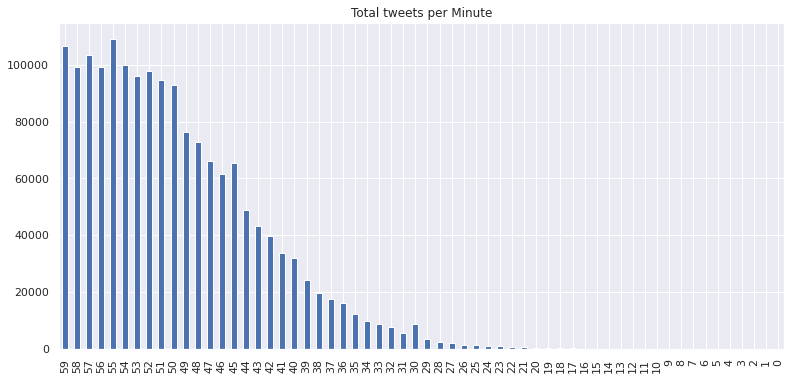

In [14]:
(tweets_df["created_at"]
 .dt.minute
 .value_counts()
 .sort_index(ascending=False)
 .plot.bar(title="Total tweets per Minute"));

**Non-uniform distribution per hour**

I query ~300 tweets per hour, using the Twitter API v2,
based on a certain keywords and conditions.
This means that for every hour I gather the relevant tweets but with chronological order, not based on popularity. So, as one can see in the distribution, the vast majority of tweets lies in the later half of the hour and I don't have much information about the first half.


**Possible Work-arounds:**

* Query based on popularity and not chronologicaly (doesn't supported in Twitter API v2).
* write more specific queries to exclude irrelevant tweets
* Query tweets from specific accounts only
* Query all tweets

In [15]:
# Total number of tweets per Hour
print("Total number of tweets per Hour")
tweets_df["created_at"].dt.hour.value_counts().sort_index(ascending=True)

Total number of tweets per Hour


0     70667
1     70703
2     70505
3     70332
4     70512
5     70642
6     70394
7     70445
8     70776
9     70359
10    70380
11    70519
12    70338
13    70058
14    70192
15    70237
16    70448
17    70417
18    70576
19    70538
20    70327
21    70395
22    70589
23    69594
Name: created_at, dtype: int64

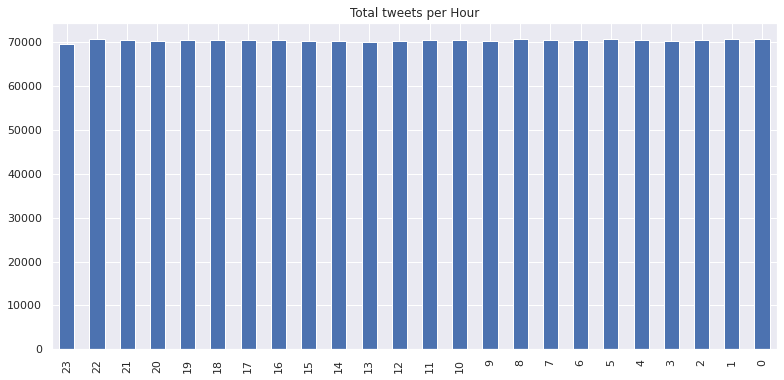

In [16]:
(tweets_df["created_at"]
 .dt.hour
 .value_counts()
 .sort_index(ascending=False)
 .plot.bar(title="Total tweets per Hour"));

In [17]:
# Total number of tweets per Date
print("Total number of tweets per Date")
tweets_df["created_at"].dt.date.value_counts().sort_index()

Total number of tweets per Date


2021-01-01    6741
2021-01-02    6635
2021-01-03    6500
2021-01-04    6376
2021-01-05    6409
              ... 
2021-08-27    7062
2021-08-28    7062
2021-08-29    7040
2021-08-30    7063
2021-08-31    6780
Name: created_at, Length: 243, dtype: int64

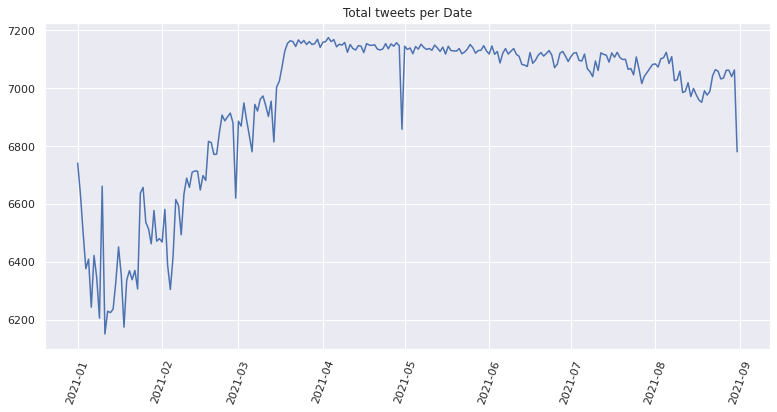

In [18]:
(tweets_df["created_at"]
 .dt.date
 .value_counts()
 .sort_index(ascending=True)
 .plot.line(title="Total tweets per Date", rot=70));

In [19]:
# Total number of tweets per Date
print("Total number of tweets per Month")
tweets_df["created_at"].dt.month.value_counts().sort_index()

Total number of tweets per Month


1    198738
2    187131
3    217888
4    214139
5    221183
6    213323
7    219699
8    217842
Name: created_at, dtype: int64

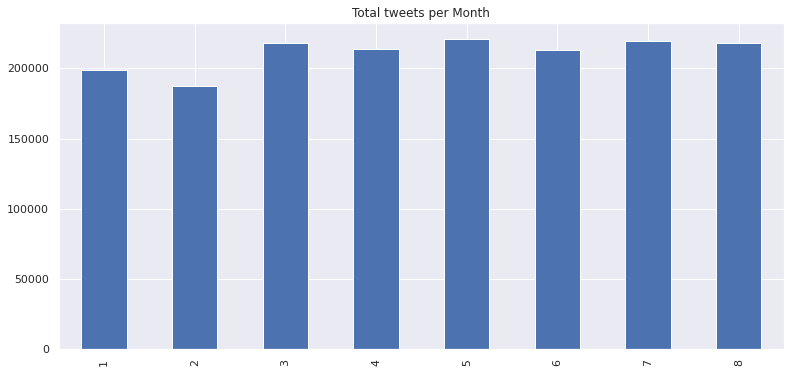

In [20]:
(tweets_df["created_at"]
 .dt.month
 .value_counts()
 .sort_index(ascending=True)
 .plot.bar(title="Total tweets per Month"));

In [21]:
# Descriptive Statistics: Tweet metrics
(tweets_df
 [["like_count", "quote_count", "reply_count", "retweet_count"]]
 .describe(percentiles=[x/100 for x in range(0,100,10)]))

,like_count,quote_count,reply_count,retweet_count
count,1.689943e+06,1.689943e+06,1.689943e+06,1.689943e+06
mean,9.670482e+00,4.139264e-01,1.585697e+00,2.943078e+00
std,1.411310e+02,4.097717e+01,4.846184e+01,1.030875e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
0%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
10%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
20%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
30%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
40%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


**Conclusions**

Most of the tweets have **low to none impression** to community (likes, quotes, replies, retweets). But there are few tweets that are influencials and they attract the vast majority of community's attention.

In [22]:
# What's the minimum minute for every hour.
# If the minute is too high, we can conclude that there are many tweets this hour.

## WordCloud

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
# WordCloud?

In [ ]:
# Concatanate tweets on a single string
text = " ".join(review for review in tweets_df["text"])
total_words = len(text)
print (f"There are {total_words} words in the combination of all tweets.")

# Lower case the words
text = text.lower()

unique_words = set(text)
total_unique_words = len(unique_words)
print (f"The unique words are {total_unique_words}")

In [ ]:
# unique_words

In [ ]:
# Create stopword list and update it with other common words
stopwords = set(STOPWORDS)
stopwords.update(["ethereum","ether","eth", "bitcoin","btc",
                  "https","t", "u", "b s", "m", "gt","co",
                  "s","amp"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Most common words
wordcloud.words_

In [ ]:
# from plotly_wordcloud import plotly_wordcloud as pwc
# from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode(connected=True)
# iplot(pwc(text))

## Find Influencers

In [ ]:
# "like_count", "quote_count", "reply_count", "retweet_count"
tweets_df.sort_values("like_count", ascending=False).head(5)

* There are plenty of popular tweets, which doesn't belong to colleted accounts in `twitter_accounts.txt` dataset.
* Check specific tweet based on tweet_id: https://twitter.com/papaemman_pan/status/tweet_id

In [ ]:
# Filter tweets with low impression (without likes, retweets, retweets, replies)
threshold = 1_000
var = "like_count"

influencial_tweets_df = tweets_df.query(f" {var} > {threshold}")
print(f"There are {len(influencial_tweets_df)} tweets with more than {threshold} {var}")

In [ ]:
fig = px.line(influencial_tweets_df,
              x="created_at", y="like_count",
              title='Total likes for influencial tweets',
              hover_name="author_id", # username
              hover_data=["created_at", "like_count","tweet_id","text"])
fig.show()

# NLP

In [23]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')

In [24]:
## Text preprocesing

# 1. lower_case
tweets_df['text'] = tweets_df['text'].str.lower()

## VADER

**Sentiment Analysis using VADER**

https://github.com/cjhutto/vaderSentiment

**`VADER` (Valence Aware Dictionary and sEntiment Reasoner)** is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. It is fully open-sourced under the [MIT License] (we sincerely appreciate all attributions and readily accept most contributions, but please don't hold us liable).

The **`compound score`** is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between **-1 (most extreme negative) and +1 (most extreme positive)**. This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

It is also useful for researchers who would like to **set standardized thresholds** for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

* **positive sentiment**: `compound score >= 0.05`
* **neutral sentiment**: `(compound score > -0.05) and (compound score < 0.05)`
* **negative sentiment**: `compound score <= -0.05`

NOTE: The compound score is the one most commonly used for sentiment analysis by most researchers, including the authors.

In [25]:
## // DEV: Experiment with VADER //

## Extract a sentense
sentence = (tweets_df
            .sort_values("like_count", ascending=False)
            .iloc[2]["text"])

print(sentence)

## VADER
sid_obj = SentimentIntensityAnalyzer()
sentiment_dict = sid_obj.polarity_scores(sentence)
print("Overall sentiment dictionary is : ", sentiment_dict)
print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative")
print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral")
print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive")

🚨 we are excited to announce our despace spacedrop! 😱 $50,000 worth of prizes! 🎁

📢 for your chance to be one of 2,000 lucky $des token winners, please follow the steps outlined in our medium article below👇

➡️https://t.co/rrdpnonfjo

#airdrop #airdropalert #defi #nft $eth
Overall sentiment dictionary is :  {'neg': 0.081, 'neu': 0.627, 'pos': 0.292, 'compound': 0.9214}
sentence was rated as  8.1 % Negative
sentence was rated as  62.7 % Neutral
sentence was rated as  29.2 % Positive


In [26]:
tweets_df.head()

,author_id,created_at,tweet_id,text,like_count,quote_count,reply_count,retweet_count,created_at_date,created_at_date_hour
0,1334365558259679238,2021-01-01 00:59:21+00:00,1344810410805919745,i've got a discount running on the nootropic i...,0,0,0,0,2021-01-01,2021-01-01 0
1,862148214,2021-01-01 00:59:17+00:00,1344810392594202624,happy new year everyone. \n\nhttps://t.co/v0yx...,0,0,0,0,2021-01-01,2021-01-01 0
2,1339254429862727681,2021-01-01 00:59:14+00:00,1344810380909043717,"2020 recap\n\n3 artists (roberto hernández, 3p...",1,0,0,0,2021-01-01,2021-01-01 0
3,1129381702407741441,2021-01-01 00:58:52+00:00,1344810289204764674,analytics firm reveals that whales are startin...,0,0,0,0,2021-01-01,2021-01-01 0
4,2933596550,2021-01-01 00:58:47+00:00,1344810265884430336,happy new year #swapfolio community!\n\nthanks...,9,0,0,4,2021-01-01,2021-01-01 0


In [27]:
# import swifter

Note that `swifter` will not work automatically for **string columns**. When using strings, Swifter will fallback to a “simple” Pandas apply, which will not be parallel. In this case, even forcing it to use dask will not create performance improvements, and you would be better off just splitting your dataset manually and parallelizing using multiprocessing.

In [ ]:
## Calculate sentiment for each tweet

def extract_sentiment(sentence):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    return sentiment_dict["compound"]

# Extract a sample of tweets
# tweets_df = tweets_df.sample(1000)
# tweets_df = tweets_df[:10_000]

tweets_df['sentiment'] = (tweets_df['text']
                          # .swifter.apply(lambda x: extract_sentiment(x))
                          .progress_apply(lambda x: extract_sentiment(x))
                         )

 37%|███▋      | 627798/1689943 [1:27:52<3:15:43, 90.45it/s] 

In [ ]:
## Work-around: Create a random sentiment column
tweets_df['sentiment'] = np.random.uniform(low=-1,high=1, size=len(tweets_df))

In [ ]:
# Most positive tweets
positive_tweets_df = (tweets_df
                      .sort_values("sentiment", ascending=False)
                      .head(5)
                      .sort_values("created_at")
                      [["author_id", "created_at", "text", "sentiment"]])
positive_tweets_df

In [ ]:
# Most negative tweets
negative_tweets_df = (tweets_df
                      .sort_values("sentiment")
                      .head(5)
                      .sort_values("created_at")
                      [["author_id","created_at", "text", "sentiment"]])
negative_tweets_df

## Plots

In [ ]:
# Extract most positive and most negative tweets and plot them
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=negative_tweets_df["created_at"],
                         y=negative_tweets_df["sentiment"],
                         mode='lines+markers',
                         text=negative_tweets_df['text'],
                         hovertemplate="<p>%{text}</p>",
                         name='Most Negative tweets',
                         line=dict(color='red')))

fig.add_trace(go.Scatter(x=positive_tweets_df["created_at"],
                         y=positive_tweets_df["sentiment"],
                         mode='lines+markers',
                         name='Most Positive tweets',
                         line=dict(color='green')))


fig.show()

In [ ]:
# Γράφημα stacked bar plot για κάθε ημέρα πόσο είναι θετικό, πόσο αρνητικό, πόσο neutral
tweets_df["sentiment_val"] = pd.cut(tweets_df["sentiment"], bins = [-1, -0.05, 0.05, 1],
                                    labels=['negative', 'neutral', 'positive'])

sentiment_proportions = (tweets_df
                         .groupby("created_at_date_hour")
                         ["sentiment_val"]
                         .value_counts(normalize=True)
                         .to_frame())

sentiment_proportions = sentiment_proportions.rename(columns={"sentiment_val":"sentiment_proportions"})
sentiment_proportions = sentiment_proportions.reset_index()

In [ ]:
sentiment_proportions.head(6)

In [ ]:
fig = px.bar(sentiment_proportions[:3*22],
             x="created_at_date_hour",
             y="sentiment_proportions", color="sentiment_val",
             title="Proportion of sentiment per day",
            color_discrete_sequence=["lightgreen", "royalblue", "red"])

fig.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=sentiment_proportions.query("sentiment_val=='positive'")["created_at_date_hour"],
                         y=sentiment_proportions.query("sentiment_val=='positive'")["sentiment_proportions"],
                         mode='lines+markers',
                         name='Positive tweets',
                         line=dict(color='lightgreen')))

fig.add_trace(go.Scatter(x=sentiment_proportions.query("sentiment_val=='neutral'")["created_at_date_hour"],
                         y=sentiment_proportions.query("sentiment_val=='neutral'")["sentiment_proportions"],
                         mode='lines+markers',
                         name='Neutral tweets',
                         line=dict(color='royalblue')))


fig.add_trace(go.Scatter(x=sentiment_proportions.query("sentiment_val=='negative'")["created_at_date_hour"],
                         y=sentiment_proportions.query("sentiment_val=='negative'")["sentiment_proportions"],
                         mode='lines+markers',
                         name='Negative tweets',
                         line=dict(color='red')))

fig.update_layout(title='Proportion of sentiment in tweets',
                   xaxis_title='Date',
                   yaxis_title='Proportion')

fig.show()

# Store Final Dataset

In [ ]:
tweets_df.head()

In [ ]:
# Store the final dataset (Try parquet)
tweets_df.to_pickle("../data/tweets_df_sentiment.pkl")